# Scaled Dot-Product Attention

**The mechanism that lets tokens communicate**

## This Is Where the Magic Happens

If there's one idea that makes transformers work, it's attention. This is the mechanism that lets each token "look at" other tokens and gather relevant information.

Consider the sentence: "The animal didn't cross the street because it was too tired."

What does "it" refer to? A human instantly knows it's "the animal" (not "the street"—streets don't get tired). But how would a model figure this out?

With attention. When processing "it", the model can attend to all previous words, compute which ones are relevant (high attention to "animal", low attention to "street"), and pull in that information. The representation of "it" becomes enriched with information about what it refers to.

This is the core innovation: **dynamic, content-based information routing**. Unlike fixed connections in a traditional neural network, attention lets the model decide, based on the actual content, where to look.

## The Query-Key-Value Framework

Attention uses three projections of each token:

| Component | Symbol | Intuition | Question It Answers |
|-----------|--------|-----------|---------------------|
| **Query** | $Q$ | What am I looking for? | "I need information about X" |
| **Key** | $K$ | What do I contain? | "I have information about Y" |
| **Value** | $V$ | What information do I carry? | "Here's my actual content" |

Think of it like a fuzzy database lookup:
- You issue a **query** (what you're searching for)
- Each item has a **key** (its index/label)
- If query matches key, you get the **value** (the content)

But unlike a normal database where matches are exact, attention is "soft": every key contributes something, weighted by how well it matches the query. Good matches contribute more; poor matches contribute less (but not zero).

## The Attention Formula

The complete scaled dot-product attention formula:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V$$

Let's break this into steps:

1. **Compute attention scores**: $\text{scores} = QK^T$
   - Dot product between each query and each key
   - Higher dot product = better match

2. **Scale**: $\text{scaled} = \frac{\text{scores}}{\sqrt{d_k}}$
   - Prevents scores from getting too large in high dimensions
   - Keeps softmax in a well-behaved range

3. **Apply causal mask** (for decoder models):
   - Set future positions to $-\infty$ so they get zero attention
   - Position $i$ can only attend to positions $\leq i$

4. **Softmax**: Convert scores to probabilities
   - Each row sums to 1
   - Larger scores → larger weights

5. **Weighted sum**: $\text{output} = \text{weights} \cdot V$
   - Combine values according to attention weights
   - Each output is a weighted average of all values

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np

## Step 1: Computing Attention Scores

The first step is computing how well each query matches each key. We use the dot product:

$$\text{score}_{ij} = Q_i \cdot K_j = \sum_{d=1}^{d_k} Q_{i,d} \cdot K_{j,d}$$

In matrix form, $QK^T$ computes all pairwise dot products at once:

$$\text{scores} = QK^T \in \mathbb{R}^{n \times n}$$

where $n$ is the sequence length.

**Why dot product?** It measures similarity. If two vectors point in the same direction, their dot product is large and positive. If they're orthogonal, it's zero. If they point in opposite directions, it's negative.

So $\text{score}_{ij}$ measures: how similar is query $i$ to key $j$?

In [2]:
# Let's compute attention scores step by step
batch_size = 1
seq_len = 5
d_k = 64  # dimension per head

# Random Q, K, V (in practice these come from linear projections)
Q = torch.randn(batch_size, seq_len, d_k)
K = torch.randn(batch_size, seq_len, d_k)
V = torch.randn(batch_size, seq_len, d_k)

# Step 1: Compute raw scores
# Q @ K^T: (batch, seq_len, d_k) @ (batch, d_k, seq_len) = (batch, seq_len, seq_len)
scores = torch.matmul(Q, K.transpose(-2, -1))

print(f"Q shape: {Q.shape}")
print(f"K shape: {K.shape}")
print(f"Scores shape: {scores.shape}")
print(f"\nScores matrix (position i attending to position j):")
print(scores[0].numpy().round(2))

Q shape: torch.Size([1, 5, 64])
K shape: torch.Size([1, 5, 64])
Scores shape: torch.Size([1, 5, 5])

Scores matrix (position i attending to position j):
[[ -0.73   6.74  -1.1    7.63  -7.69]
 [ -6.64  -2.68  -5.66  16.31  -4.63]
 [  6.78 -14.12  -2.59  -4.46  -9.21]
 [  8.19  -1.54  -2.44 -18.09  -1.14]
 [ 12.37  -9.98   9.17   2.25   0.94]]


### Understanding the Score Matrix

The score matrix is $n \times n$ (sequence length × sequence length):
- Row $i$ contains the scores for query $i$ against all keys
- $\text{score}_{ij}$ = how much should position $i$ attend to position $j$?

Higher score = better match = more attention.

## Step 2: Scaling

We divide the scores by $\sqrt{d_k}$:

$$\text{scaled\_scores} = \frac{QK^T}{\sqrt{d_k}}$$

**Why scale?** This is subtle but important.

When $d_k$ is large, the dot products can become large in magnitude. If $Q$ and $K$ have elements with variance 1, then the dot product has variance $d_k$ (it's a sum of $d_k$ products).

Large dot products push softmax into regions where gradients are tiny. Imagine softmax on `[0.1, 0.2, 0.3]` vs `[10, 20, 30]`:
- First case: `[0.30, 0.33, 0.37]` — smooth distribution
- Second case: `[0.00, 0.00, 1.00]` — nearly one-hot, gradients vanish

Dividing by $\sqrt{d_k}$ keeps the variance of scores at roughly 1, keeping softmax in a healthy range.

In [3]:
# Step 2: Scale
scale = math.sqrt(d_k)
scaled_scores = scores / scale

print(f"Scaling factor: sqrt({d_k}) = {scale:.2f}")
print(f"\nBefore scaling - variance: {scores.var().item():.2f}")
print(f"After scaling - variance: {scaled_scores.var().item():.2f}")
print(f"\nScaled scores:")
print(scaled_scores[0].numpy().round(3))

Scaling factor: sqrt(64) = 8.00

Before scaling - variance: 67.45
After scaling - variance: 1.05

Scaled scores:
[[-0.092  0.842 -0.138  0.953 -0.962]
 [-0.83  -0.335 -0.708  2.039 -0.579]
 [ 0.848 -1.764 -0.324 -0.558 -1.151]
 [ 1.024 -0.193 -0.305 -2.261 -0.142]
 [ 1.547 -1.248  1.146  0.281  0.118]]


## Step 3: Causal Masking

For decoder-only models (GPT, Claude, LLaMA), we need **causal masking**: each position can only attend to previous positions (and itself), not future ones.

Why? Because during generation, we predict tokens one at a time. When predicting token $t$, we only have access to tokens $0, 1, ..., t-1$. If the model could attend to future tokens during training, it would "cheat" and the model wouldn't learn to actually predict.

We implement this by setting future positions to $-\infty$ before softmax:

$$\text{masked}_{ij} = \begin{cases} \text{scaled}_{ij} & \text{if } j \leq i \\ -\infty & \text{if } j > i \end{cases}$$

Why $-\infty$? Because $\text{softmax}(e^{-\infty}) = 0$. These positions contribute nothing.

In [4]:
def create_causal_mask(seq_len: int) -> torch.Tensor:
    """
    Create a causal mask that prevents attending to future positions.
    
    Returns a matrix where mask[i,j] = True if j > i (should be masked).
    """
    # Upper triangular matrix of True values (future positions)
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
    return mask

# Visualize the mask
mask = create_causal_mask(seq_len)

print("Causal mask (True = can't attend):")
print(mask.int().numpy())
print()
print("Reading the mask:")
print("  Position 0: can only see [0]")
print("  Position 1: can see [0, 1]")
print("  Position 2: can see [0, 1, 2]")
print("  Position 4: can see [0, 1, 2, 3, 4] (all)")

Causal mask (True = can't attend):
[[0 1 1 1 1]
 [0 0 1 1 1]
 [0 0 0 1 1]
 [0 0 0 0 1]
 [0 0 0 0 0]]

Reading the mask:
  Position 0: can only see [0]
  Position 1: can see [0, 1]
  Position 2: can see [0, 1, 2]
  Position 4: can see [0, 1, 2, 3, 4] (all)


In [5]:
# Apply the mask
masked_scores = scaled_scores.clone()
masked_scores = masked_scores.masked_fill(mask, float('-inf'))

print("Masked scores (future positions = -inf):")
# Print with nicer formatting
for i in range(seq_len):
    row = []
    for j in range(seq_len):
        val = masked_scores[0, i, j].item()
        if val == float('-inf'):
            row.append('  -inf')
        else:
            row.append(f'{val:6.2f}')
    print(f"  [{', '.join(row)}]")

Masked scores (future positions = -inf):
  [ -0.09,   -inf,   -inf,   -inf,   -inf]
  [ -0.83,  -0.34,   -inf,   -inf,   -inf]
  [  0.85,  -1.76,  -0.32,   -inf,   -inf]
  [  1.02,  -0.19,  -0.30,  -2.26,   -inf]
  [  1.55,  -1.25,   1.15,   0.28,   0.12]


## Step 4: Softmax

Now we convert scores to attention weights using softmax:

$$\text{weight}_{ij} = \frac{e^{\text{score}_{ij}}}{\sum_k e^{\text{score}_{ik}}}$$

Softmax does three things:

1. **Exponentiates**: Makes all values positive
2. **Normalizes**: Makes each row sum to 1 (a probability distribution)
3. **Amplifies differences**: Larger scores get disproportionately larger weights

The result: attention weights that sum to 1 for each query position.

In [6]:
# Step 4: Softmax (along the last dimension - over keys)
attention_weights = F.softmax(masked_scores, dim=-1)

print("Attention weights (each row sums to 1):")
print(attention_weights[0].numpy().round(3))
print()
print("Row sums (should all be 1.0):")
print(attention_weights[0].sum(dim=-1).numpy().round(4))

Attention weights (each row sums to 1):
[[1.    0.    0.    0.    0.   ]
 [0.379 0.621 0.    0.    0.   ]
 [0.723 0.053 0.224 0.    0.   ]
 [0.626 0.185 0.166 0.023 0.   ]
 [0.444 0.027 0.297 0.125 0.106]]

Row sums (should all be 1.0):
[1. 1. 1. 1. 1.]


### Interpreting Attention Weights

Look at the attention weights:

- **Position 0**: 100% attention to itself (no choice—it can only see itself)
- **Position 1**: Distributes attention between positions 0 and 1
- **Later positions**: Spread attention across all visible positions

The weights are fairly uniform because Q, K are random. In a trained model, you'd see much more interesting patterns:
- Pronouns attending strongly to their antecedents
- Verbs attending to subjects
- Punctuation attending to sentence beginnings

## Step 5: Weighted Sum of Values

Finally, we compute the output as a weighted sum of values:

$$\text{output}_i = \sum_j \text{weight}_{ij} \cdot V_j$$

In matrix form:

$$\text{output} = \text{attention\_weights} \cdot V$$

Each output vector is a weighted combination of all value vectors, where the weights come from attention. Positions with high attention contribute more to the output.

In [7]:
# Step 5: Weighted sum of values
# (batch, seq_len, seq_len) @ (batch, seq_len, d_k) = (batch, seq_len, d_k)
output = torch.matmul(attention_weights, V)

print(f"Attention weights shape: {attention_weights.shape}")
print(f"Values shape: {V.shape}")
print(f"Output shape: {output.shape}")
print()
print("Each output position is a weighted average of value vectors.")

Attention weights shape: torch.Size([1, 5, 5])
Values shape: torch.Size([1, 5, 64])
Output shape: torch.Size([1, 5, 64])

Each output position is a weighted average of value vectors.


## Putting It All Together

Let's wrap the complete attention mechanism in a class:

In [8]:
class ScaledDotProductAttention(nn.Module):
    """
    Scaled dot-product attention mechanism.
    
    Computes: Attention(Q, K, V) = softmax(QK^T / sqrt(d_k)) V
    """
    
    def __init__(self, dropout: float = 0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
    
    def forward(
        self, 
        query: torch.Tensor, 
        key: torch.Tensor, 
        value: torch.Tensor, 
        mask: torch.Tensor = None
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            query: (batch, seq_len, d_k)
            key: (batch, seq_len, d_k)
            value: (batch, seq_len, d_v)  # d_v often equals d_k
            mask: optional boolean mask, True = mask out
        
        Returns:
            output: (batch, seq_len, d_v)
            attention_weights: (batch, seq_len, seq_len)
        """
        d_k = query.size(-1)
        
        # Step 1: Compute raw scores
        scores = torch.matmul(query, key.transpose(-2, -1))
        
        # Step 2: Scale
        scores = scores / math.sqrt(d_k)
        
        # Step 3: Apply mask (if provided)
        if mask is not None:
            scores = scores.masked_fill(mask, float('-inf'))
        
        # Step 4: Softmax
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Step 5: Weighted sum
        output = torch.matmul(attention_weights, value)
        
        return output, attention_weights

In [9]:
# Test the complete attention module
attention = ScaledDotProductAttention(dropout=0.0)

# Create inputs
batch_size, seq_len, d_k = 2, 6, 64
Q = torch.randn(batch_size, seq_len, d_k)
K = torch.randn(batch_size, seq_len, d_k)
V = torch.randn(batch_size, seq_len, d_k)

# Causal mask
mask = create_causal_mask(seq_len)

# Forward pass
output, weights = attention(Q, K, V, mask=mask)

print(f"Input shapes: Q={Q.shape}, K={K.shape}, V={V.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {weights.shape}")

Input shapes: Q=torch.Size([2, 6, 64]), K=torch.Size([2, 6, 64]), V=torch.Size([2, 6, 64])
Output shape: torch.Size([2, 6, 64])
Attention weights shape: torch.Size([2, 6, 6])


## Visualizing Attention Patterns

Attention weights are interpretable—we can visualize what each position is "looking at".

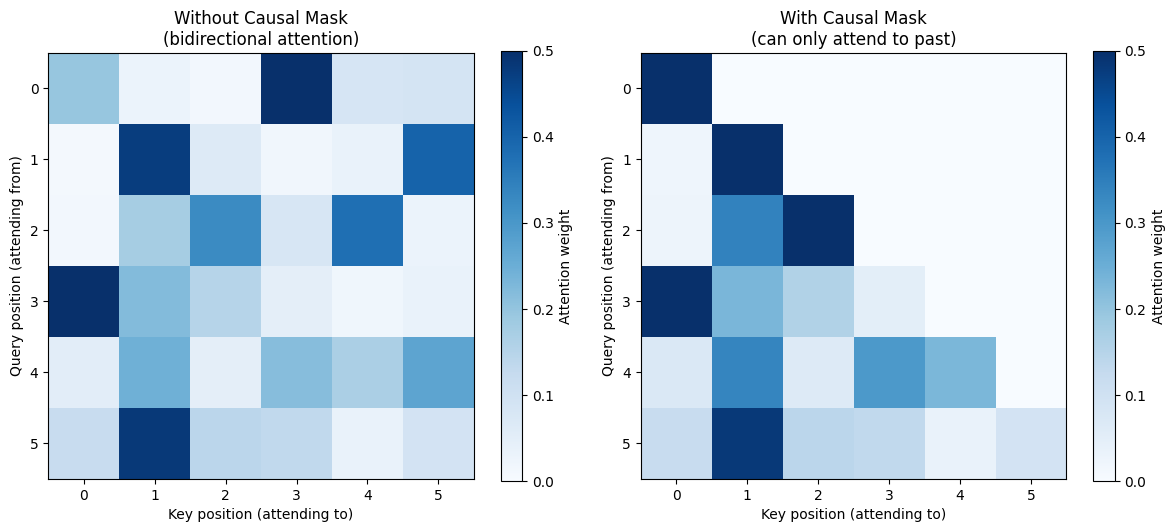

Notice: with causal mask, all weights above the diagonal are zero.
Each position can only attend to itself and earlier positions.


In [10]:
# Visualize attention patterns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Without causal mask
output_full, weights_full = attention(Q, K, V, mask=None)

ax = axes[0]
im = ax.imshow(weights_full[0].detach().numpy(), cmap='Blues', vmin=0, vmax=0.5)
ax.set_title('Without Causal Mask\n(bidirectional attention)')
ax.set_xlabel('Key position (attending to)')
ax.set_ylabel('Query position (attending from)')
plt.colorbar(im, ax=ax, label='Attention weight')

# With causal mask
ax = axes[1]
im = ax.imshow(weights[0].detach().numpy(), cmap='Blues', vmin=0, vmax=0.5)
ax.set_title('With Causal Mask\n(can only attend to past)')
ax.set_xlabel('Key position (attending to)')
ax.set_ylabel('Query position (attending from)')
plt.colorbar(im, ax=ax, label='Attention weight')

plt.tight_layout()
plt.show()

print("Notice: with causal mask, all weights above the diagonal are zero.")
print("Each position can only attend to itself and earlier positions.")

## The Complete Picture: From Input to Output

Let's trace through what happens to a single position:

```
Position 3 processing:

1. Q[3] = "What am I looking for?"
   K[0,1,2,3] = "What does each visible position offer?"

2. Compute scores:
   score[3,0] = Q[3] · K[0]  →  0.52
   score[3,1] = Q[3] · K[1]  →  0.31
   score[3,2] = Q[3] · K[2]  →  0.89
   score[3,3] = Q[3] · K[3]  →  0.45

3. Scale by sqrt(d_k)

4. Softmax → weights that sum to 1:
   weight[3,0] = 0.21
   weight[3,1] = 0.15
   weight[3,2] = 0.42  ← Position 2 is most relevant!
   weight[3,3] = 0.22

5. Weighted sum:
   output[3] = 0.21·V[0] + 0.15·V[1] + 0.42·V[2] + 0.22·V[3]
```

The output for position 3 is now a blend of information from all visible positions, weighted by relevance.

## Where Do Q, K, V Come From?

We've been using random Q, K, V. In a real transformer, they come from **learned linear projections** of the input:

$$Q = XW_Q, \quad K = XW_K, \quad V = XW_V$$

where:
- $X \in \mathbb{R}^{n \times d_{model}}$ is the input (token embeddings + position)
- $W_Q, W_K, W_V \in \mathbb{R}^{d_{model} \times d_k}$ are learned weight matrices

The model learns what projections are useful:
- $W_Q$ learns what to search for
- $W_K$ learns how to be found
- $W_V$ learns what information to transmit

These three different projections are crucial. The same token needs to play different roles: what it's looking for (query) is different from what it offers (key) which is different from what it contains (value).

In [11]:
# Self-attention with learned projections
class SelfAttention(nn.Module):
    """
    Self-attention with learned Q, K, V projections.
    
    This is the basic building block. Multi-head attention (next notebook)
    runs multiple of these in parallel.
    """
    
    def __init__(self, d_model: int, d_k: int, dropout: float = 0.1):
        super().__init__()
        
        # Learned projections
        self.W_q = nn.Linear(d_model, d_k, bias=False)
        self.W_k = nn.Linear(d_model, d_k, bias=False)
        self.W_v = nn.Linear(d_model, d_k, bias=False)
        
        self.attention = ScaledDotProductAttention(dropout)
        self.d_k = d_k
    
    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        """
        Args:
            x: (batch, seq_len, d_model) - input embeddings
            mask: optional causal mask
        
        Returns:
            output: (batch, seq_len, d_k)
            weights: (batch, seq_len, seq_len)
        """
        # Project input to Q, K, V
        Q = self.W_q(x)  # (batch, seq_len, d_k)
        K = self.W_k(x)
        V = self.W_v(x)
        
        # Compute attention
        output, weights = self.attention(Q, K, V, mask)
        
        return output, weights

In [12]:
# Test self-attention
d_model = 256
d_k = 64
batch_size, seq_len = 2, 10

self_attn = SelfAttention(d_model, d_k)

# Input embeddings
x = torch.randn(batch_size, seq_len, d_model)
mask = create_causal_mask(seq_len)

output, weights = self_attn(x, mask)

print(f"Input: {x.shape}")
print(f"Output: {output.shape}")
print(f"\nParameters:")
for name, param in self_attn.named_parameters():
    print(f"  {name}: {param.shape}")

Input: torch.Size([2, 10, 256])
Output: torch.Size([2, 10, 64])

Parameters:
  W_q.weight: torch.Size([64, 256])
  W_k.weight: torch.Size([64, 256])
  W_v.weight: torch.Size([64, 256])


## Key Takeaways

1. **Attention computes dynamic, content-based connections** between positions

2. **Q, K, V serve different roles**:
   - Query: what am I looking for?
   - Key: what do I offer?
   - Value: what information do I carry?

3. **Scaling by $\sqrt{d_k}$** keeps softmax in a well-behaved range

4. **Causal masking** prevents looking at future tokens (essential for generation)

5. **Output is a weighted sum of values**, where weights come from query-key compatibility

## Next: Multi-Head Attention

One attention head can only focus on one type of relationship at a time. What if a word needs to attend to its subject AND its object AND related concepts?

The solution: run multiple attention heads in parallel, each with its own Q, K, V projections. Each head can learn to focus on different aspects of the input.

In the next notebook, we'll implement multi-head attention and see how it enables richer representations.